In [13]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(0)
seed(0)

In [14]:
train = pd.read_csv('dataset/train.csv')
labels = pd.read_csv('dataset/labels.csv')
test = pd.read_csv('dataset/sample_submission.csv')

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

train["id"] = train["id"].apply(lambda x:x+".png")
test["id"] = test["id"].apply(lambda x:x+".png")

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [15]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0001
HEIGHT = 64
WIDTH = 64
CANAL = 3
N_CLASSES = labels.shape[0]
classes = list(map(str, range(N_CLASSES)))

In [17]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="dataset/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="dataset/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "dataset/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 3460 validated image filenames belonging to 1103 classes.
Found 864 validated image filenames belonging to 1103 classes.
Found 7443 validated image filenames.


In [21]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', input_shape=(HEIGHT, WIDTH, CANAL)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation="sigmoid"))
model.summary()

optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy"])
# model.compile(optimizer=optimizer, loss="binary_crossentropy",metrics=["accuracy", "categorical_accuracy"])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        25632     
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)       

In [27]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    verbose=1)

model.save('model')

Epoch 1/10
54/54 [==============================] - 57s 1s/step - loss: 4.5721 - accuracy: 0.1652 - categorical_accuracy: 0.1652 - val_loss: 6.0345 - val_accuracy: 0.0625 - val_categorical_accuracy: 0.0625
Epoch 2/10
54/54 [==============================] - 51s 935ms/step - loss: 4.2782 - accuracy: 0.1979 - categorical_accuracy: 0.1979 - val_loss: 6.2041 - val_accuracy: 0.0661 - val_categorical_accuracy: 0.0661
Epoch 3/10
54/54 [==============================] - 52s 962ms/step - loss: 4.0392 - accuracy: 0.2132 - categorical_accuracy: 0.2132 - val_loss: 6.3326 - val_accuracy: 0.0649 - val_categorical_accuracy: 0.0649
Epoch 4/10
54/54 [==============================] - 52s 959ms/step - loss: 3.8415 - accuracy: 0.2306 - categorical_accuracy: 0.2306 - val_loss: 6.1948 - val_accuracy: 0.0697 - val_categorical_accuracy: 0.0697
Epoch 5/10
54/54 [==============================] - 51s 946ms/step - loss: 3.6631 - accuracy: 0.2512 - categorical_accuracy: 0.2512 - val_loss: 5.9273 - val_accuracy: 

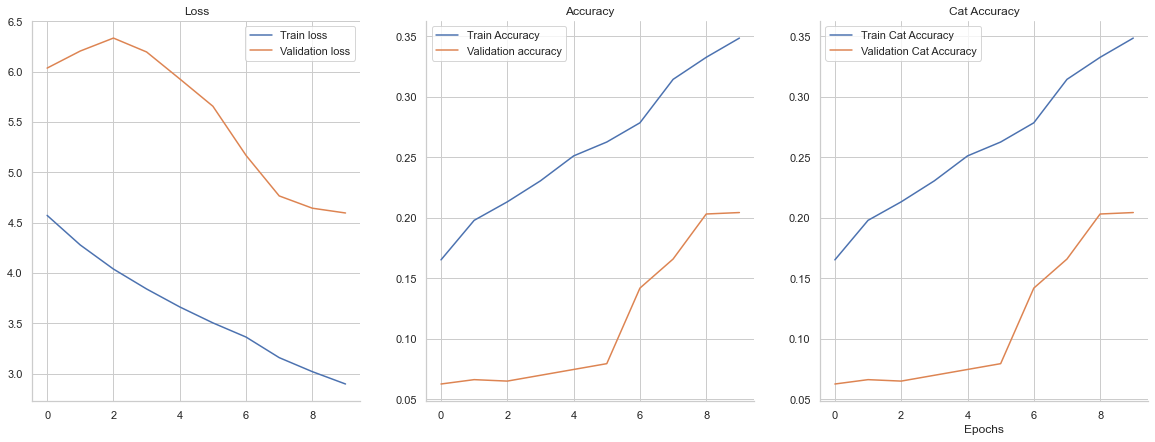

In [30]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()